# Universidad de Chile - FCFM

# - Proyecto Final - Simulated annealing Aplicado a Sistema de Metro de Santiago de Chile

MA4402-1 - Simulación Estocástica: Teoría y Laboratorio

Profesor: Joaquín Fontobona T.

Auxiliares: Catalina Lizana, Álvaro Márquez, Matías Ortiz

20 de Diciembre de 2023

**Integrantes:**

- Allen Arroyo
- Isidora Miranda

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import scipy as sc
import numpy as np
import random
import math

from scipy.stats import uniform

# 1. Introducción:

Nuestro proyecto tiene como objetivo minimizar el tiempo total de espera de transferencia de pasajeros entre diferentes líneas de metro a traves de la sincronización de los primeros trenes de salida de cada linea de metro, los tiempos de espera en cada estación(dwell) y los tiempos de traslado entre cada estación.

Para aquello fue aplicado un algoritmo basado en Simulated annealing en una simplificación de la red de metro de Santiago de Chile utilizando datos generados por variables aleatorias uniformes. El procedimiento es analogo al realizado en el Paper https://doi.org/10.1016/j.apm.2015.05.008 que se encuentra respectivamente en las referencias de nuestro resumen en formato PDF. En aquél trabajo los investigadores se desempeñarón en la red de metro de la ciudad de Beijing(China) obteniendo buenos resultados finales.

Entonces, Santiado de Chile presenta la siguiente red de metro actualizada a 2023(incluye proximas estaciones):

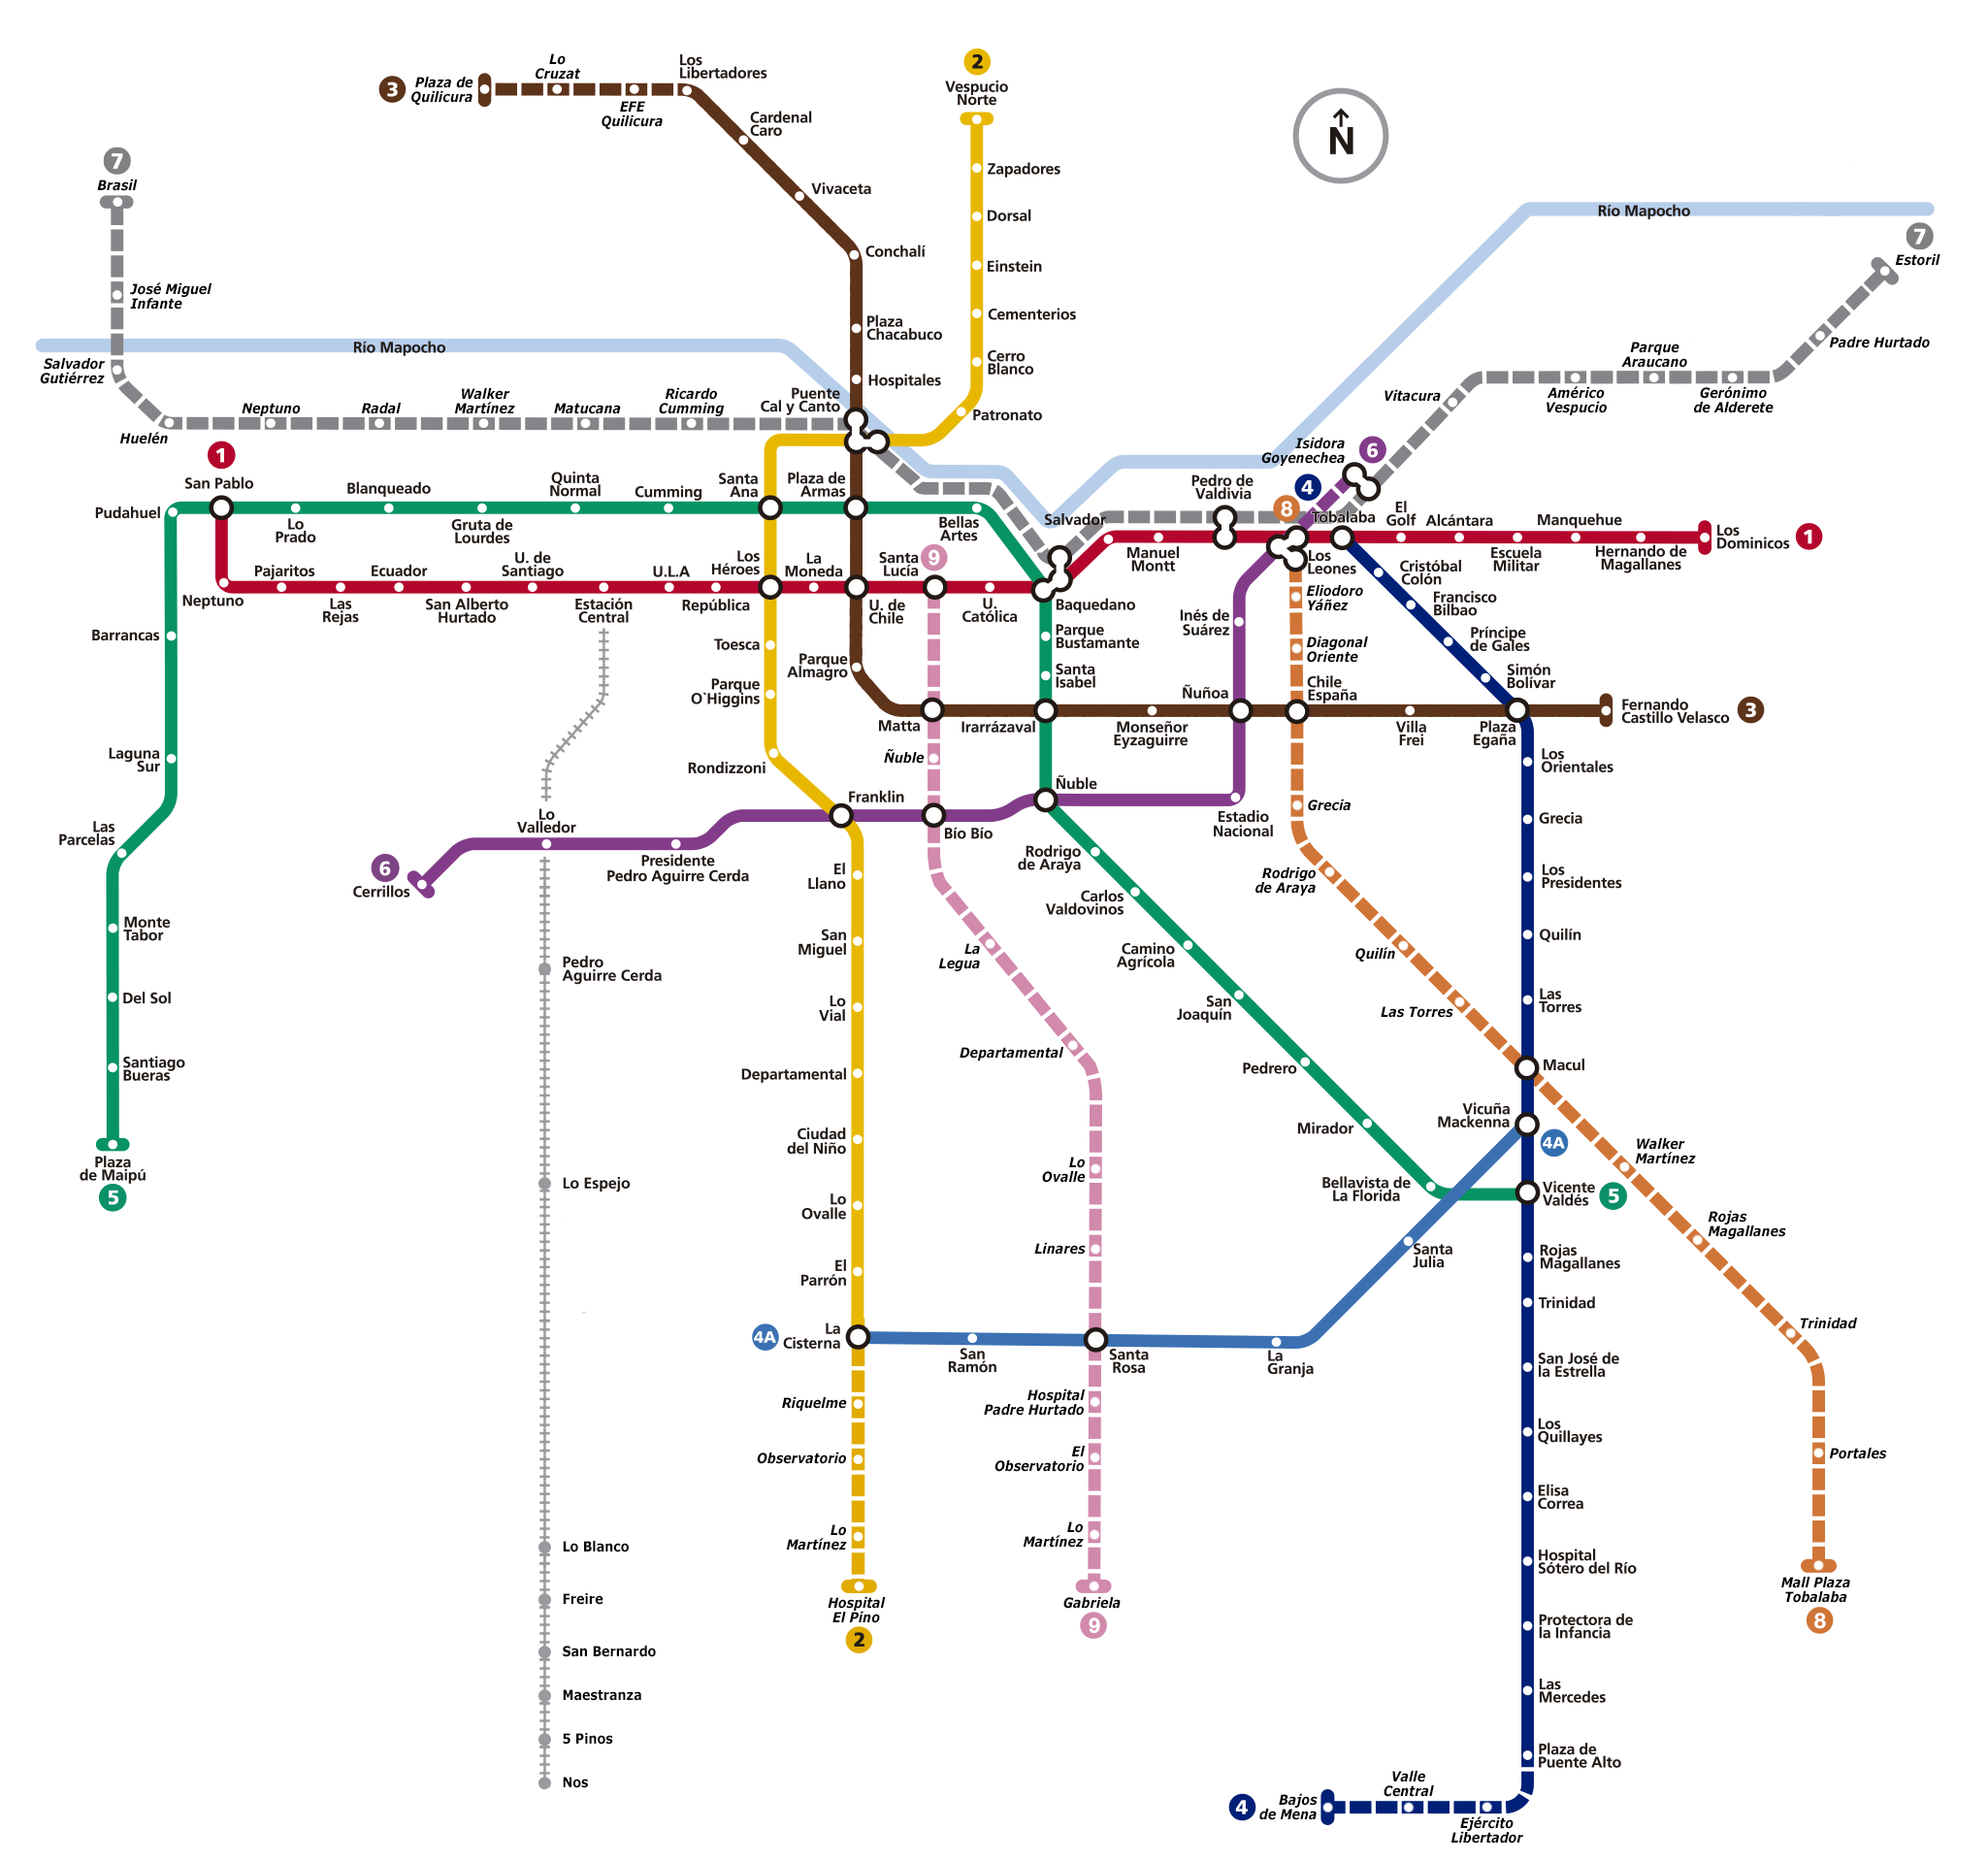

In [2]:
# @title Red Metro de Santiago de Chile

#from google.colab import drive
#drive.mount('/content/drive')

from IPython.display import Image
Image("red_metro.png")

# 2. implificación, red de metro reducida:

Dada la magnitud de estaciones totales y lineas de metro se decide en este proyecto aplicar primeramente los algoritmos a una simplflicación. La  simplflicación mencionada es la siguiente :

Donde tenemos un total de 3 lineas de metro $ L = \{l_1,l_2,l_3\}$, 2 primeros trenes para cada linea(uno UP y otro DOWN) y 3 estaciones con conexiones entre lineas.

Se tendrá posteriormente que trabajar con "6 lineas" efectivas, es decir,

$$L = \{l^{up}_1,l^{down}_1, l^{up}_2, l^{down}_2, l^{up}_3, l^{down}_3 \}$$

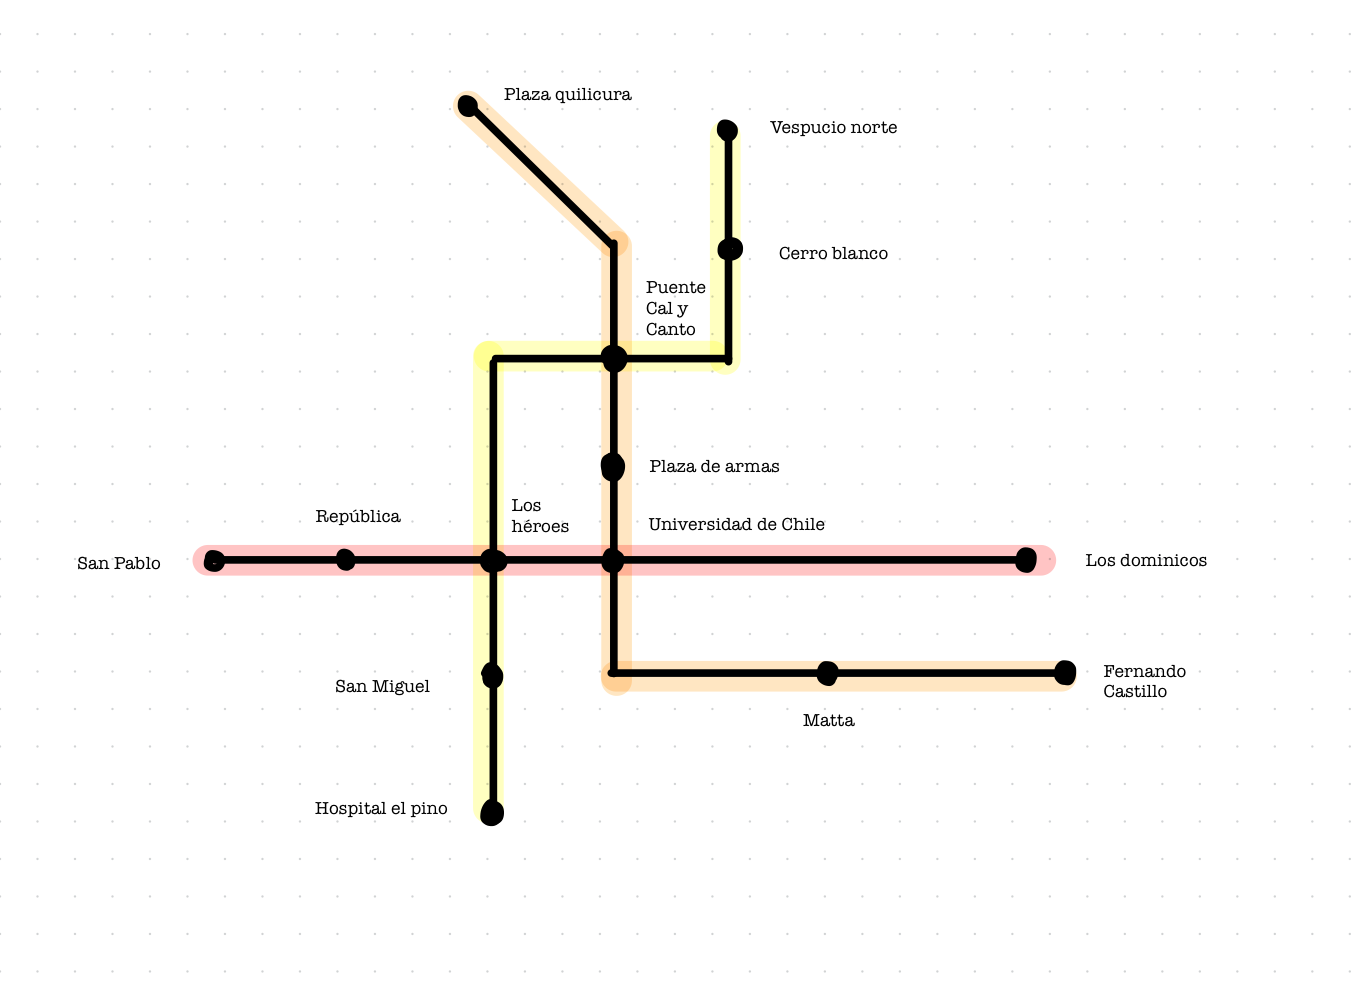

In [3]:
# @title Simplifcación Inicial red de metro de Santiago
#Image("/content/drive/MyDrive/2023 Segundo Semestre Fcfm/Simulación Estocastica/Proyecto Final /Imagenes /Imagen PNG.png")
Image("Imagen PNG.png")

# 3. Generación de dataset:

Tenemos 3 lineas con las que trabajaremos:

In [4]:
l1 = ["san pablo", "republica","los heroes", "universidad de chile", "los dominicos"]
l2 = ["hospital el pino", "san miguel", "los heroes", "puente cal y canto", "cerro blanco", "vespucio norte"]
l3 = ["plaza quilicura","puente cal y canto", "plaza de armas","universidad de chile","matta","fernando castillo"]

len_l1 = len(l1)
len_l2 = len(l2)
len_l3 = len(l3)

Donde tenemos los siguentes datos generados por v.a uniformes:

- **$Headways$**: En 1er lugar tenemos los tiempo entre estaciones de la misma linea l de metro, por simplicidad para el otra dirección de la linea $l$ los tiempos son iguales, es decir, si

```
tiempos_entre_estaciones_1_up = [76, 84, 30, 89]
```
entonces
```
tiempos_entre_estaciones_1_down = [89, 30, 84, 76]
```

In [5]:
# Headways: Vectores tiempo entre estaciones de la misma linea l de metro.

np.random.seed(42)

def Headways(longitud):
    # Genera un vector con valores aleatorios entre 30 y 90
    vector = [random.randint(40, 60*3) for _ in range(longitud)]
    return vector

Headways_1=Headways(len_l1-1)
Headways_2=Headways(len_l2-1)
Headways_3=Headways(len_l3-1)



In [6]:
Headways_1,Headways_2,Headways_3

([126, 90, 149, 104], [136, 142, 108, 168, 120], [145, 118, 50, 103, 67])

* **$Dwell_u$**: En 2do lugar tenemos el tiempo que de permanencia del tren en la estación $u$.

Notar que en las estaciones terminales de cada linea $l$ no existen tiempos de este tipo dada su definición.  

In [7]:
#Dwell: Vectores tiempo en estaciones
np.random.seed(42)

def Dwell(longitud):
    # Genera un vector con valores aleatorios entre 5 y 10
    vector =[0]
    vector += [random.randint(10, 40) for _ in range(longitud-2)]
    vector += [0]
    return vector

Dwell_1= Dwell(len_l1)
Dwell_2= Dwell(len_l2)
Dwell_3= Dwell(len_l3)

In [8]:
Dwell_1,Dwell_2,Dwell_3

([0, 35, 22, 10, 0], [0, 37, 27, 33, 17, 0], [0, 24, 15, 34, 12, 0])

* **$t_0$**: En 3er lugar tenemos el tiempo de partida desde la estacion terminal en la linea l.

Entonces para cada linea existen dos tiempos $t_0$, uno que llamaremos $t^{up}_{0}$ y otro $t^{down}_{0}$ debido a las dos direcciones de cada liena $l$, posteriormente se denotará como:

$$up:= 0 \hspace{4mm}  ; \hspace{4mm} down:= 1$$


In [9]:
#t0: Vectores tiempo de partida de la estacion terminal en la linea l
np.random.seed(42)

# En Chile todas las estaciones abren a las 5:00, damos un margen para la salida de los trenes
# de 600 segundos, es decir, 10 minutos

def t_0(terminales) :
    # Genera un vector con valores aleatorios entre 0 y 10
    vector = [random.randint(0, 800) for _ in range(terminales)]
    return vector

t0_1=t_0(2)
t0_2=t_0(2)
t0_3=t_0(2)


In [10]:
t0_1,t0_2,t0_3

([306, 694], [8, 423], [482, 732])

* Agrupamos los tiempos en con sus respectivos maximos y minimos:


```
tR,tDw,t0
```



In [11]:
def vector_tiempo(vector_1,vector_2,vector_3):
  # Unir los vectores
  vector_unido = [vector_1]+[vector_2]+[vector_3]
  #x = vector_1 + vector_2 + vector_3
# Calcular el mínimo y máximo
  #minimo = min(x)
  #maximo = max(x)

  return vector_unido

tR=vector_tiempo(Headways_1,Headways_2,Headways_3)
tDw=vector_tiempo(Dwell_1,Dwell_2,Dwell_3)
t0=vector_tiempo(t0_1,t0_2,t0_3)


In [12]:
tR, tDw,t0

([[126, 90, 149, 104], [136, 142, 108, 168, 120], [145, 118, 50, 103, 67]],
 [[0, 35, 22, 10, 0], [0, 37, 27, 33, 17, 0], [0, 24, 15, 34, 12, 0]],
 [[306, 694], [8, 423], [482, 732]])

* Maximos y minimos para $(t^R,t^{Dw},t^{0})$ :


In [13]:
# Para los 3 tiempos:
def max_min(tR,tDw,t0) :
  t = [tR,tDw,t0]
  tmaxmin = []
  for l in t :
    tmaxmin_l = []
    for j in range(0,3) :
      maximo = max(l[j])
      minimo = min(l[j])
      if l == tR :
        maximo += 100
        minimo -= 10
      if l == tDw :
        maximo += 20
        if minimo == 0:
          minimo = 5

      if l == t0 :
        maximo += 300
        minimo += 50
      tmaxmin_l += [[maximo,minimo]]
    tmaxmin += [tmaxmin_l]
  return tmaxmin




# Para un 1 tiempo:
def max_min_t(tipo):

  if tipo=="tR":
    maximo=60*3
    minimo=40
  if tipo=="tDw":
    maximo=40
    minimo=10
  if tipo=="t0":
    maximo=0
    minimo=800


  return [maximo,minimo]

In [14]:
max_min(tR,tDw,t0)

[[[249, 80], [268, 98], [245, 40]],
 [[55, 5], [57, 5], [54, 5]],
 [[994, 356], [723, 58], [1032, 532]]]

In [15]:
max_min_t("tR")

[180, 40]

# 4. Calculo de tiempos para función objetivo:

1. $t^{A}_{sl}$: tiempos de llegada a estación $s$ del primer tren de linea $l$ en dirección $up := 0$ o $down := 1$. Se definen como:

$$ t^{A}_{sl} = t^{0}_{l} + \sum\limits_{k=2}^s t^{R}_{lk(k-1)} + \sum\limits_{k=1}^{s-1} t^{Dw}_{lk} $$



In [16]:
#Nos generamos una funcion que nos invierta las listas que usaremos, para calcular los tiempo de llegada y parada en las lineas
# dependiendo de la direccion de viaje en la linea.

# arreglo: list o numpy array con arreglo[0] lista de interes.

def invertir_sublistas(arreglo):
    arreglo_invertida = [sublista[::-1] for sublista in arreglo]
    return arreglo_invertida

# Ejemplo:
x = [[1, 2, 3], [4, 5], [1, 1, 2]]
x_inv = invertir_sublistas(x)
x_inv

[[3, 2, 1], [5, 4], [2, 1, 1]]

In [17]:

#tiempos de llegadas a las estaciones, dependiendo de la linea
# l: linea de metro l in {1,2,3}

def CalcularTiempoLlegadal(l, t0, tR, tDw, direccion):

    #tR =  tR[0]
    #t0 =  t0[0]
    #tDw = tDw[0]

    # Invertir las listas de tR y tDw
    tR_in = invertir_sublistas(tR)
    tDw_in = invertir_sublistas(tDw)

    resultados0 = []
    resultados1 = []

    if direccion==0: # dirección up(izquieda a derecha ó de abajo a arriba)
      tsl = 0
      for s in range(0, len(tDw[l-1])) :
        tsl = t0[l-1][direccion] # t[l-1][0] será los tiempos de salida del primer tren en la linea l

        for k in range(0,s):
          tsl += tR[l-1][k]     # tR[l-1][k] será el tiempo de traslado entre estación k-1 y k

        for k in range(0,s):    # tDw[l-1][k] será el tiempo de permanencia en la estación k
          tsl += tDw[l-1][k]
        resultados0.append(tsl)
      return resultados0

    if direccion==1:   # dirección dow(derecha a izquieda ó de arriba a abajo)
      for s in range(0, len(tDw[l-1])):
        tsl = t0[l-1][direccion]

        for k in range(0,s):
          tsl += tR_in[l-1][k]

        for k in range(0,s):
          tsl += tDw_in[l-1][k]
        resultados1.append(tsl)
      return resultados1

# Ejemplo:

t0x = [[10, 20], [0, 10], [20, 5]]
tRx = [[1, 2, 3], [4, 5], [1, 1, 2]]
tDwx = [[0, 3, 4, 0], [0, 5, 0], [0, 1, 2, 0]]
l = 1
x = CalcularTiempoLlegadal(l, t0x, tRx, tDwx, 0)
y = CalcularTiempoLlegadal(l, t0x, tRx, tDwx, 1)
x,y

([10, 11, 16, 23], [20, 23, 29, 33])

2. $t^{D}_{sl}$: tiempos de salida de la estación $s$ del primer tren de linea $l$ en dirección $up := 0$ o $down := 1$. Se definen como:

$$ t^{D}_{sl} = t^{0}_{l} + \sum\limits_{k=2}^s t^{R}_{lk(k-1)} + \sum\limits_{k=1}^{s} t^{Dw}_{lk} $$

In [18]:
#tiempos de partida de las estaciones, dependiendo de la linea
def CalcularTiempoSalidal(l, t0, tR, tDw, direccion):

    #tR =  tR[0]
    #t0 =  t0[0]
    #tDw = tDw[0]

    # Invertir las listas de tR y tDw
    tR_in = invertir_sublistas(tR)
    tDw_in = invertir_sublistas(tDw)

    resultados0 = []
    resultados1 = []

    if direccion==0: # dirección up(izquieda a derecha ó de abajo a arriba)
      tsl = 0
      for s in range(0, len(tDw[l-1])) :
        tsl = t0[l-1][direccion] # t[l-1][0] será los tiempos de salida del primer tren en la linea l

        for k in range(0,s):
          tsl += tR[l-1][k]     # tR[l-1][k] será el tiempo de traslado entre estación k-1 y k

        for k in range(0,s+1):    # tDw[l-1][k] será el tiempo de permanencia en la estación k
          tsl += tDw[l-1][k]
        resultados0.append(tsl)
      return resultados0

    if direccion==1:   # dirección dow(derecha a izquieda ó de arriba a abajo)
      for s in range(0, len(tDw[l-1])):
        tsl = t0[l-1][direccion]

        for k in range(0,s):
          tsl += tR_in[l-1][k]

        for k in range(0,s+1):
          tsl += tDw_in[l-1][k]
        resultados1.append(tsl)
      return resultados1

# Ejemplo:

t0x = [[10, 20], [0, 10], [20, 5]]
tRx = [[1, 2, 3], [4, 5], [1, 1, 2]]
tDwx = [[0, 3, 4, 0], [0, 5, 0], [0, 1, 2, 0]]

l = 1
x = CalcularTiempoSalidal(l, t0x, tRx, tDwx, 0)
y = CalcularTiempoSalidal(l, t0x, tRx, tDwx, 1)
x,y

([10, 14, 20, 23], [20, 27, 32, 33])

3. $t^{Tra}_{sll'}$: tiempo de transferencia caminando en estación de conexión s desde linea $l$ a linea $l'$.

Este valor es un parametro fijo(dado) y suponemos simetrico(puede no serlo necesariamente), es decir, dada estación $s$ fija $$t^{Tra}_{sll'} = t^{Tra}_{sl'l}$$


In [19]:
# Definicion de tTra:
np.random.seed(42)

Heroes = random.randint(1*60,8*60)
Universidad_Chile = random.randint(2*60,6*60)
Cal_y_canto = random.randint(1*60,5*60)

tTra = [Heroes,Universidad_Chile, Cal_y_canto]
tTra

[223, 287, 157]

4. $T^{H}_{l'}$: intervalo de tiempo entre trenes consecutivos en la linea $l'$.

Este valor es un parametro fijo al igual que el anterior y se define respecto al primer tren de salida de cada linea $l'$.

Lo establecemos simetrico, puede no serlo necesariamente.


In [20]:
np.random.seed(42)

linea1 = random.randint(6*60,8*60)
linea2 = random.randint(3*60,5*60)
linea3 = random.randint(5*60,8*60)

tH = [linea1,linea2,linea3]
tH

[411, 268, 362]

5. Finalmente nos queda definir $t^{w}_{sll'}$ como:

$$ t^{w}_{sll'} = h \cdot T^{H}_{l'} + t^{D}_{sl'} - (t^{A}_{sl}+ T^{Tra}_{sll'})$$

Notar que es definido por 1. 2. 3. y 4. **Aquél tiempo será calculado en sección SA algortimo**.

#  5. Vector Modifying Algorithm y Solution Generation Algorithm:

Para aplicar el algoritmo SA(Simulated Annealing) necesitamos construir tiempos adecuados para generar soluciones factibles. Definiendo nuestra función objetivo a minimizar como:

$$ f(i) = \sum\limits_{s \in S(l) \cap S(l')} \sum\limits_{l \in L} \sum\limits_{l' \in L} t^{w(i)}_{sll'}$$

tenemos que para cada itereación de SA requerimos nuevos $t^{w(i)}_{sll'}$ para posteriormente calcular $\Delta f = f(i+1)-f(i)$  y aplicar los criteriors de SA respectivamente.

Vamos a tener que $L = \{l_1,l_2,l_3\}$ es realmente  $L = \{l^{up}_1,l^{down}_1, l^{up}_2, l^{down}_2, l^{up}_3, l^{down}_3 \}$, es decir, tenemos 6 lineas de metro efectivas. Esto es devido a que es diferente tomar un linea de metro según su dirección, donde cada linea presenta dos direcciones. Cuando se defina la función en codigo para calcular $f(i)$ se verán más detalles.


1. Vector Modifying Algorithm: Para este proyecto seguimos el pseudo-algoritmo documentado en las referencias [1] (link directo: https://doi.org/10.1016/j.apm.2015.05.008).

Notar que la función fue aplicada para cada linea de metro, es decir para $t^{R}_{l},t^{0}_{l}$ y $t^{Dw}_{l}$ donde $l \in \{1,2,3\}$

In [21]:
# t : arreglo de tiempos(en segundos) de cada tipo, es decir, tR,tDw o t0
# en x se encuentran los tiempos de las 3 lineas
# ejemplo: t <- [[32, 54, 51, 46], [70, 33, 83, 34, 78], [33, 79, 43, 61, 80]]

# M : cota a elegir positiva y grande con respecto a los valores a trabajar
# tipo : string, puede ser "tR","tDw" o "t0" es para calcular los maximos y minimos
np.random.seed(42)
import copy

def Vector_Modifying(t,M1,M2,tipo):

   arreglo = copy.deepcopy(t)
   maxmin = max_min_t(tipo)
   solutionNew = []

   for j in range(0,len(arreglo)) :
    lmax = maxmin[0]
    lmin = maxmin[1]

    p = len(arreglo[j])
    pi = random.randint(1, p)  # Se elige un índice aleatorio en [1, p]
    u = random.uniform(-M1, M2)  # Se elige un número aleatorio en [-M, M], donde M es un valor positivo y grande
    l_pi = arreglo[j][pi-1]
   # Se realiza la modificación del elemento en la posición pi
    modified_value = l_pi*u

   # Se verifica si el valor modificado está fuera de los límites
    if modified_value > lmax :
          modified_value = lmax
    if modified_value < lmin :
        modified_value = lmin
   # else: return modified_value se mantiene
   # Se actualiza el valor en la posición pi
    else:
      arreglo[j][pi-1] = modified_value # lo estamos modificando directamente en el arreglo  arreglo[j].
    solutionNew += [arreglo[j]]
   return solutionNew

# Ejemplo:
tiempos = [[32, 54, 32, 46], [70, 33, 83, 34, 33], [33, 33, 43, 61, 80]]
M1 = 0.8
M2 = 1.1
z = Vector_Modifying(tiempos,M1,M2,"tR")
z

[[32, 54, 32, 46], [70, 33, 83, 34, 33], [33, 33, 43, 61, 80]]

2. Solution Generation Algorithm :

Aplicamos la función anterior para los arreglos $t^{R},t^{0}$ y $t^{Dw}$

In [22]:

# Aplica el algoritmo de modificación de vector a los tiempos entre estaciones del metro, los tiempos de permanencia en estaciones
# y los horarios de salida desde la estacion terminal

def solution_generator(tR,tDw,t0,M1,M2):
    k1 = Vector_Modifying(tR,M1,M2,"tR")  # los tiempos entre estaciones del metro
    k2 = Vector_Modifying(tDw,M1,M2,"tDw") # los tiempos de permanencia en estaciones
    k3 = Vector_Modifying(t0,M1,M2,"t0")  # los horarios de salida desde la estacion terminal
    return k1,k2,k3

In [23]:
tR,tDw,t0

([[126, 90, 149, 104], [136, 142, 108, 168, 120], [145, 118, 50, 103, 67]],
 [[0, 35, 22, 10, 0], [0, 37, 27, 33, 17, 0], [0, 24, 15, 34, 12, 0]],
 [[306, 694], [8, 423], [482, 732]])

In [24]:
solution_generator(tR,tDw,t0,0.5,1.1)

([[126, 90, 160.29025094720842, 104],
  [136, 142, 108, 168, 66.65478201413259],
  [145, 118, 50, 103, 67]],
 [[0, 35, 22, 10, 0],
  [0, 37, 27, 32.27490072438093, 17, 0],
  [0, 24, 15, 34, 12, 0]],
 [[306, 694], [8, 423], [482, 732]])

# 6. Definición de timempos $t^{w}_{sll'}$ :

1. Vamos a escribir el algoritmo final que aplica SA, pero en primer lugar necesitamos determinar los tiempos $t^{w}_{sll'}$ explicitamente.

Acá lo complejo como enunciamos anteriormente es que las lineas de metro de nuestra simplificación ya no son 3, si no que realmente son 6, es decir, $$L = \{l^{up}_1,l^{down}_1, l^{up}_2, l^{down}_2, l^{up}_3, l^{down}_3 \}$$ Entonces en total para determinar $t^{w}_{sll'}$ con $$s \in S(l) \cap S(l') = \{\text{"los heroes"},\text{"universidad de chile"},\text{"puente cal y canto"}\}$$

vamos a tener $8 \cdot 3 = 24$ opciones(8 por estación de conexión).

In [25]:

def tw(linea_inicial,linea_final,direccion1,direccion2,tR,tDw,t0,h=1):

  ta= CalcularTiempoLlegadal(linea_inicial, t0, tR, tDw, direccion1)
  td=CalcularTiempoSalidal(linea_final, t0, tR, tDw, direccion2)

  th,tD,tA,trans=0,0,0,0

  #combinacion en los heroes l1 a l2
  if linea_inicial==1 and linea_final==2:
    trans=tTra[0] #tranferencia caminando en los heroes
    th = tH[1]
    if direccion1==0 and direccion2==0:
      tA=ta[2]
      tD=td[2]
    if direccion1==1 and direccion2==1:
      tA=ta[2]
      tD=td[3]


    if direccion1==0 and direccion2==1:
      tA=ta[2]
      tD=td[3]

    if direccion1==1 and direccion2==0:
      tA=ta[2]
      tD=td[2]

  #combinacion en los heroes l2 a l1
  if linea_inicial==2 and linea_final==1:
    th = tH[0]
    trans=tTra[0] #tranferencia caminando en los heroes
    if direccion1==0 and direccion2==0:
      tA=ta[2]
      tD=td[2]

    if direccion1==1 and direccion2==1:
      tA=ta[3]
      tD=td[2]


    if direccion1==0 and direccion2==1:
      tA=ta[2]
      tD=td[2]

    if direccion1==1 and direccion2==0:
      tA=ta[3]
      tD=td[2]

  #combinacion en cal y canto l2 a l3
  if linea_inicial==2 and linea_final==3:
    th = tH[2]
    trans=tTra[2]
    if direccion1==0 and direccion2==0:
      tA=ta[3]
      tD=td[1]
    if direccion1==1 and direccion2==1:
      tA=ta[2]
      tD=td[4]
    if direccion1==0 and direccion2==1:
      tA=ta[3]
      tD=td[4]
    if direccion1==1 and direccion2==0:
      tA=ta[2]
      tD=td[1]

  #combinacion en cal y canto l3 a l2
  if linea_inicial==3 and linea_final==2:
    trans=tTra[2]
    th = tH[1]
    if direccion1==0 and direccion2==0:
      tA=ta[1]
      tD=td[3]
    if direccion1==1 and direccion2==1:
      tA=ta[4]
      tD=td[2]
    if direccion1==0 and direccion2==1:
      tA=ta[1]
      tD=td[2]
    if direccion1==1 and direccion2==0:
      tA=ta[4]
      tD=td[3]

  #combinancion en u de chile l1 a l3
  if linea_inicial==1 and linea_final==3:
    th = tH[2]
    trans=tTra[1]
    if direccion1==0 and direccion2==0:
      tA=ta[3]
      tD=td[3]
    if direccion1==1 and direccion2==1:
      tA=ta[1]
      tD=td[2]
    if direccion1==0 and direccion2==1:
      tA=ta[3]
      tD=td[2]
    if direccion1==1 and direccion2==0:
      tA=ta[1]
      tD=td[3]

  #combinancion en u de chile l3 a l1
  if linea_inicial==3 and linea_final==1:
    trans=tTra[1]
    th = tH[0]
    if direccion1==0 and direccion2==0:
      tA=ta[3]
      tD=td[3]
    if direccion1==1 and direccion2==1:
      tA=ta[2]
      tD=td[1]
    if direccion1==0 and direccion2==1:
      tA=ta[3]
      tD=td[1]
    if direccion1==1 and direccion2==0:
      tA=ta[2]
      tD=td[3]
  tw = h*th + tD-(tA+trans)
  return tw


In [26]:
# Ejemplo:
t1 = tR
t2 = tDw
t3 = t0
# tw(linea_inicial,linea_final,direccion1,direccion2,tR,tDw,t0,h=1)
tw(3,1,1,1,t1,t2,t3,h=1)

18

# 7. SA(Simulated Annealing) Algoritmo:

SA requiere una función de energía, la que respectivamente es nuestra función objetivo:

2. Ahora definimos la función objetivo en codigo y posteriomente SA

$$ f_{i} = \sum\limits_{s \in S(l) \cap S(l')} \sum\limits_{l \in L} \sum\limits_{l' \in L} (t^{w}_{sll'})_i$$

donde $i$ representa una 3-tupla $(t^{R}_{i},t^{Dw}_{i},t^{0}_{i})$.

In [27]:
# calcula f suma total de los tw

def f(tR,tDw,t0):
    suma_total = 0

    for linea_inicial in [1, 2, 3]:
        for linea_final in [1, 2, 3]:
            for direccion1 in [0, 1]:
                for direccion2 in [0, 1]:
                    suma_total += tw(linea_inicial,linea_final,direccion1,direccion2,tR,tDw,t0,h=1)
    return suma_total
#Ejemplo:

t1 = tR
t2 = tDw
t3 = t0
f(t1,t2,t3)

3592

In [28]:
np.random.seed(42)

# Algoritmo:

# inpunt: tR,tDw,t0,tH,tTra
def SA(T0,tau,omega,ML,tR,tDw,t0,M1,M2) :

  #Inicializacion:
  u = np.random.uniform(0, 1, ML)
  T = T0
  tRold,tDwold,t0old = tR,tDw,t0
  fold = f(tRold,tDwold,t0old)
  #print(fold)
  while T > tau : #3.1 if T <= tau, stop (dentro del while existe la condicion)
    #print(T)
    k = 1
    while k < ML : #2.4 if k = ML, stop (dentro del while existe la condicion)
    #2.2
      tnew = solution_generator(tRold,tDwold,t0old,M1,M2)
      #print(tnew)
      #print(tnew[0])
      tRnew,tDwnew,t0new = tnew[0],tnew[1],tnew[2]
      #print( tRnew,tDwnew,t0new)
      fnew = f(tRnew,tDwnew,t0new)
    #2.3(SA)
      delta_f = fnew - fold
      if delta_f <= 0 :
          fold = fnew
          tRold,tDwold,t0old =  tRnew,tDwnew,t0new
      else :
        rho = min(1.0,np.exp(-delta_f/T))
        if u[k] <= rho :
          fold = fnew
          tRold,tDwold,t0old =  tRnew,tDwnew,t0new
      k += 1
    T = T*omega
  return fnew,tRnew,tDwnew,t0new

# 8. Test de Pruebas:

Realizaremos dos test de prueba, uno con numeros aleatorios y otro fijado por nosotros sencillo.


1. Test sencillo :  

Definimos los arreglos como sigue

In [29]:
T0 = 100
tau = 0.1
omega = 0.98
ML = 50
M1 = 0.7
M2 = 1.1

In [30]:
t1r = [[40, 50, 100, 120], [121, 45, 55, 60, 50], [56, 70, 50,89,102]]
t2dw = [[11, 11, 11, 11, 11], [11, 11, 11, 11, 11], [11, 11, 11, 11, 11]]
t30 = [[0, 0], [0, 0], [0, 0]]
f(t1r,t2dw,t30), t1r,t2dw,t30

(3256,
 [[40, 50, 100, 120], [121, 45, 55, 60, 50], [56, 70, 50, 89, 102]],
 [[11, 11, 11, 11, 11], [11, 11, 11, 11, 11], [11, 11, 11, 11, 11]],
 [[0, 0], [0, 0], [0, 0]])

In [31]:

s = SA(T0,tau,omega,ML,t1r,t2dw,t30,M1,M2)
s

(3233.672009948046,
 [[42.576216672842115,
   41.152309379290266,
   40.457011561619076,
   41.92184512746548],
  [45.198307023509,
   44.123301325151594,
   40.0405129552756,
   43.34257812945267,
   40.35636213571633],
  [48.59253218232313,
   41.1719379983091,
   40.09659386788292,
   44.86980834101117,
   40.57241346276221]],
 [[10.20835280560697,
   10.07361067579668,
   10.042654141751441,
   10.143953619193208,
   10.783856835092495],
  [10.765112474102171,
   10.033494537169041,
   10.079249784647114,
   10.055578892332067,
   10.60245608558143],
  [10.105617083155222,
   10.057281517349683,
   10.039527890188342,
   10.012789962644982,
   10.030996935194807]],
 [[0, 0], [0, 0], [0, 0]])

2. Test aleaotorio :

Utilizamos los arreglos generados al inicio del documento, los cuales son aleatorios :
```
tR,tDw,t0,tTra,tH
```



In [32]:
f(tR,tDw,t0),tR, tDw,t0

(3592,
 [[126, 90, 149, 104], [136, 142, 108, 168, 120], [145, 118, 50, 103, 67]],
 [[0, 35, 22, 10, 0], [0, 37, 27, 33, 17, 0], [0, 24, 15, 34, 12, 0]],
 [[306, 694], [8, 423], [482, 732]])

In [33]:
solution = SA(T0,tau,omega,ML,tR,tDw,t0,M1,M2)
solution

(3233.1136849032932,
 [[49.27194760189216, 40.93245963891175, 41.88282025530519, 45.27788630645592],
  [40.51707237984811,
   42.386927073209286,
   44.130297052869054,
   41.58131762436585,
   41.52404517466625],
  [40.630165590947314,
   41.14241158349303,
   41.03361440422862,
   42.70142163965097,
   42.95791074044397]],
 [[0, 10.607404164479433, 10.011549695438816, 10.008304794062374, 0],
  [0,
   10.37238779333708,
   10.016658540959945,
   10.034751877800995,
   10.987272897411339,
   0],
  [0,
   10.004341059010072,
   10.354617231796729,
   10.202815258551095,
   10.812659551785547,
   0]],
 [[306, 694], [8, 423], [482, 732]])

 3. función generadora de tiempos iniciales :

In [34]:
l1 = ["san pablo", "republica","los heroes", "universidad de chile", "los dominicos"]
l2 = ["hospital el pino", "san miguel", "los heroes", "puente cal y canto", "cerro blanco", "vespucio norte"]
l3 = ["plaza quilicura","puente cal y canto", "plaza de armas","universidad de chile","matta","fernando castillo"]

len_l1 = len(l1)
len_l2 = len(l2)
len_l3 = len(l3)

def generador_tiempos_iniciales(n) :
  X = []
  k = 0
  while k < n:

    Dwell_1k = Dwell(len_l1)
    Dwell_2k = Dwell(len_l2)
    Dwell_3k = Dwell(len_l3)
    Headways_1k =Headways(len_l1-1)
    Headways_2k =Headways(len_l2-1)
    Headways_3k =Headways(len_l3-1)

    tRk  =vector_tiempo(Headways_1k,Headways_2k,Headways_3k)
    tDwk =vector_tiempo(Dwell_1k,Dwell_2k,Dwell_3k)
    t0k = vector_tiempo(t_0(2),t_0(2),t_0(2))
    X += [[tRk,tDwk,t0k]]
    k += 1
  return X

In [35]:
generador_tiempos_iniciales(2)[0][0]

[[139, 63, 95, 56], [123, 154, 127, 68, 111], [56, 119, 52, 47, 62]]

In [36]:

def result_SA(n,T0,tau,omega,ML,M1,M2) :
  k = 0
  inicial = generador_tiempos_iniciales(n)
  Y = []
  X = []
  while k < n :
    tR = inicial[k][0]
    tDw = inicial[k][1]
    t0 = inicial[k][2]

    f_inicial = f(tR,tDw,t0)
    f_new  = SA(T0,tau,omega,ML,tR,tDw,t0,M1,M2)[0]
    Y += [  f_inicial ]
    X += [f_new]

    k += 1
  return X,Y

In [37]:
M1 = 0.7
M2 = 1.1
result_SA(10,100,0.1,0.98,50,M1,M2)

([3232.6742521229935,
  3233.065009062911,
  3233.2643059064662,
  3234.8367067391255,
  3233.2169471044376,
  3232.5398005859674,
  3232.8670988735844,
  3233.2687499687504,
  3232.9506383156536,
  3233.736140387215],
 [3584, 3528, 3608, 3516, 3600, 3676, 3600, 3476, 3640, 3644])

In [38]:
f_initial = [2696, 2832, 2696, 2772, 2852, 2556, 2724, 2688, 2808, 2776]
f_SA= [2401.572,
  2400.909,
  2401.571,
  2403.661,
  2400.613,
  2400.645,
  2402.184,
  2400.860,
  2400.346,
  2401.769]
len(f_initial), len(f_SA)

(10, 10)

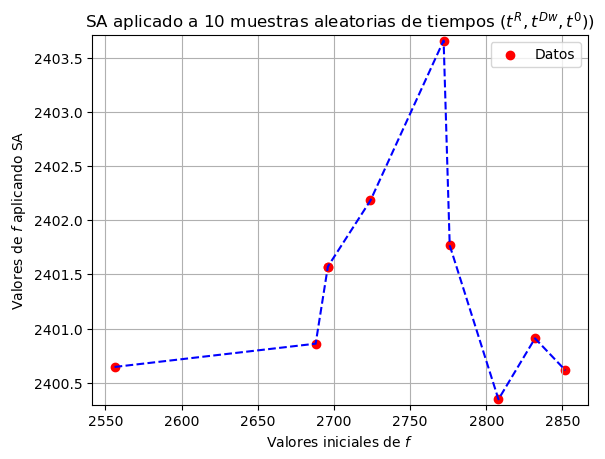

In [39]:


# Ordena los datos por el eje x (f_initial)
sorted_data = sorted(zip(f_initial, f_SA))
f_initial_sorted, f_SA_sorted = zip(*sorted_data)

plt.scatter(f_initial, f_SA,color='red', label='Datos')

plt.plot(f_initial_sorted, f_SA_sorted, color='blue', linestyle='--')

plt.xlabel(r'Valores iniciales de $f$')
plt.ylabel(r'Valores de $f$ aplicando SA')
titulo = r"SA aplicado a 10 muestras aleatorias de tiempos $(t^R,t^{Dw},t^{0})$)"
plt.title(titulo)

plt.ylim(min(f_SA) - 0.05, max(f_SA) + 0.05)
plt.grid(True)

plt.legend()
plt.show()